# Customer Segmentation

## 1) Imports

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans

sns.set_theme(style="whitegrid")
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)

RANDOM_STATE = 42

In [48]:
# Utility functions for analysis and visualization
def get_clusters_sorted(df, cluster_col="cluster"):
    """Get sorted list of unique clusters."""
    return sorted(df[cluster_col].unique())

def calculate_category_percentage(df, cluster_col, category_col, weight_col="weight"):
    """Calculate percentage distribution of a categorical variable by cluster."""
    results = {}
    for c in get_clusters_sorted(df, cluster_col):
        sub = df[df[cluster_col] == c]
        total = sub[weight_col].sum()
        results[c] = sub.groupby(category_col)[weight_col].sum() / total * 100
    return results

def get_top_category_by_cluster(df, cluster_col, category_col, weight_col="weight", top_n=1):
    """Get the top N categories for each cluster with their percentages."""
    results = {}
    for c in get_clusters_sorted(df, cluster_col):
        sub = df[df[cluster_col] == c]
        total = sub[weight_col].sum()
        top_cats = sub.groupby(category_col)[weight_col].sum().sort_values(ascending=False).head(top_n)
        if len(top_cats) > 0:
            results[c] = [(cat, val / total * 100) for cat, val in top_cats.items()]
    return results

def setup_bar_chart(ax, title, xlabel='Cluster', ylabel='%', fontsize_title=14, fontsize_labels=12):
    """Standard setup for bar charts."""
    ax.set_title(title, fontsize=fontsize_title, fontweight='bold')
    ax.set_xlabel(xlabel, fontsize=fontsize_labels)
    ax.set_ylabel(ylabel, fontsize=fontsize_labels)
    return ax

def add_labels_on_bars(ax, bars, labels, rotation=45, fontsize=9, offset=1):
    """Add text labels on top of bars."""
    for bar, label in zip(bars, labels):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + offset,
                label, ha='center', va='bottom', fontsize=fontsize, rotation=rotation)

## 2) Load data

In [29]:
census_df = pd.read_csv('census_fe.data', header=0)
print("Dataset shape:", census_df.shape)

X_fe = census_df.drop(columns=['label', 'weight', 'member of a labor union', 'migration_unknown', 'veterans benefits'])
weights = census_df['weight']
y_fe = census_df['label']

Dataset shape: (142800, 36)


In [30]:
cat_cols = ['class of worker', 'education', 'enroll in edu inst last wk', 'marital stat', 'major industry code', 'major occupation code', 'reason for unemployment', 'full or part time employment stat', 'tax filer stat', 'region of previous residence', 'detailed household summary in household', 'live in this house 1 year ago', 'citizenship']
bin_cols = ['country of birth father_us_born', 'country of birth mother_us_born', 'has_capital_gains', 'has_capital_losses', 'has_dividends_from_stocks', 'is_male', 'is_mover', 'is_nonmover', 'is_white', 'moved_within_state']
cont_cols = ['age', 'log_capital_gains', 'log_capital_losses', 'log_dividends_from_stocks', 'num persons worked for employer', 'own business or self employed', 'wage per hour', 'weeks worked in year']

preprocess_seg = ColumnTransformer(
    transformers=[
        ("cont", StandardScaler(), cont_cols),
        ("bin", "passthrough", bin_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=True), cat_cols),
    ],
    sparse_threshold=0.3
)

X_seg = preprocess_seg.fit_transform(X_fe)

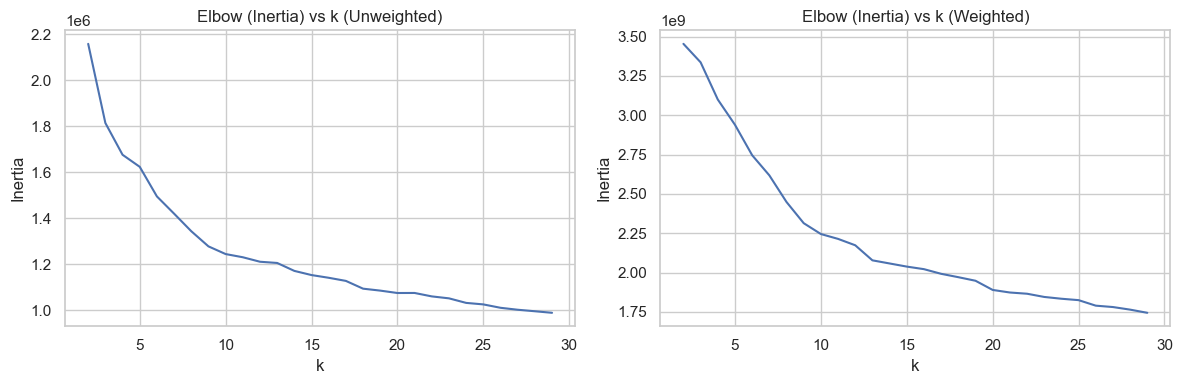

In [31]:
def eval_k_range(X, k_values, sample_weight=None, silhouette_sample=20000, random_state=0):
    inertias = []
    
    for k in k_values:
        km = KMeans(
            n_clusters=k,
            random_state=0,
            init="k-means++",
            n_init="auto",
            max_iter=300
        )
        km.fit(X, sample_weight=sample_weight)
        inertias.append(km.inertia_)

    return inertias


k_values = list(range(2, 30))

inertias_w   = eval_k_range(X_seg, k_values, sample_weight=weights)
inertias_unw = eval_k_range(X_seg, k_values, sample_weight=None)


fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(k_values, inertias_unw, label="Unweighted")
axes[0].set_title("Elbow (Inertia) vs k (Unweighted)")
axes[0].set_xlabel("k")
axes[0].set_ylabel("Inertia")


axes[1].plot(k_values, inertias_w, label="Weighted")
axes[1].set_title("Elbow (Inertia) vs k (Weighted)")
axes[1].set_xlabel("k")
axes[1].set_ylabel("Inertia")

plt.tight_layout()
plt.show()


In [32]:
# fit final clustering model based on elbow
K = 7

km_unw = KMeans(n_clusters=K, random_state=0, init="k-means++", n_init="auto", max_iter=300)
clusters_unw = km_unw.fit_predict(X_seg)

km_w = KMeans(n_clusters=K, random_state=0, init="k-means++", n_init="auto", max_iter=300)
clusters_w = km_w.fit_predict(X_seg, sample_weight=weights)


# 3) Visualize clusters using 2D projection

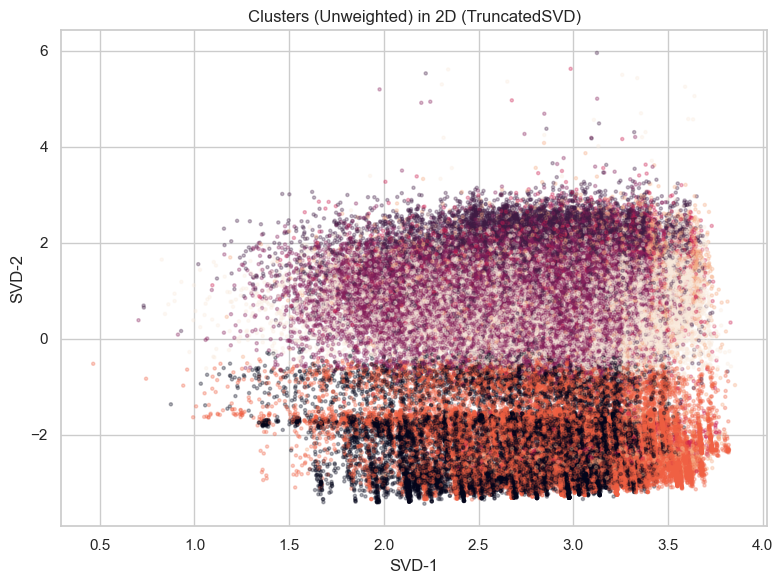

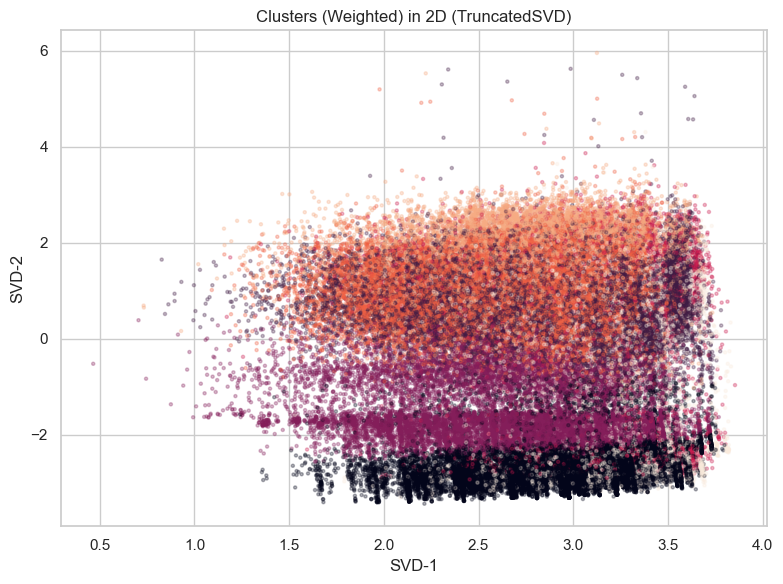

In [33]:
svd = TruncatedSVD(n_components=2, random_state=0)
X_2d = svd.fit_transform(X_seg)

def plot_clusters_2d(X2, labels, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(X2[:, 0], X2[:, 1], s=5, alpha=0.3, c=labels)
    plt.title(title)
    plt.xlabel("SVD-1")
    plt.ylabel("SVD-2")
    plt.tight_layout()
    plt.show()

plot_clusters_2d(X_2d, clusters_unw, "Clusters (Unweighted) in 2D (TruncatedSVD)")
plot_clusters_2d(X_2d, clusters_w,   "Clusters (Weighted) in 2D (TruncatedSVD)")


# 4) Cluster Analysis for Marketing

In [34]:
def weighted_mean(x, w):
    x = np.asarray(x, dtype=float)
    w = np.asarray(w, dtype=float)
    return np.sum(x * w) / np.sum(w)

def profile_segments(X_raw, y, clusters, weights=None, top_cat=5):
    dfp = X_raw.copy()
    dfp["cluster"] = clusters
    dfp["label"] = y.values if isinstance(y, pd.Series) else y

    out = []

    for c in sorted(dfp["cluster"].unique()):
        sub = dfp[dfp["cluster"] == c]

        if weights is None:
            size = len(sub)
            pos_rate = sub["label"].mean()
        else:
            w = weights[sub.index]
            size = w.sum()
            pos_rate = weighted_mean(sub["label"], w)

        row = {
            "cluster": c,
            "size": size,
            "pos_rate_(>50K)": pos_rate
        }

        # Numeric summaries (unweighted mean; can also do weighted if you want)
        for col in X_raw.select_dtypes(include=["number", "bool", "int64", "float64"]).columns:
            if weights is None:
                row[f"{col}_mean"] = sub[col].mean()
            else:
                w = weights[sub.index]
                row[f"{col}_wmean"] = weighted_mean(sub[col], w)

        # Top categories for categorical cols
        for col in X_raw.select_dtypes(include=["object"]).columns:
            top_vals = sub[col].value_counts().head(top_cat).index.tolist()
            row[f"{col}_top{top_cat}"] = ", ".join(map(str, top_vals))

        out.append(row)

    return pd.DataFrame(out).sort_values("size", ascending=False)

seg_profile_unw = profile_segments(X_fe, y_fe, clusters_unw, weights=None)
seg_profile_w   = profile_segments(X_fe, y_fe, clusters_w, weights=weights)

display(seg_profile_unw.head(10))
display(seg_profile_w.head(10))


,cluster,size,pos_rate_(>50K),age_mean,wage per hour_mean,num persons worked for employer_mean,own business or self employed_mean,weeks worked in year_mean,has_capital_gains_mean,log_capital_gains_mean,has_capital_losses_mean,log_capital_losses_mean,has_dividends_from_stocks_mean,log_dividends_from_stocks_mean,country of birth father_us_born_mean,country of birth mother_us_born_mean,is_mover_mean,is_nonmover_mean,moved_within_state_mean,is_male_mean,is_white_mean,class of worker_top5,education_top5,enroll in edu inst last wk_top5,marital stat_top5,major industry code_top5,major occupation code_top5,reason for unemployment_top5,full or part time employment stat_top5,tax filer stat_top5,region of previous residence_top5,detailed household summary in household_top5,live in this house 1 year ago_top5,citizenship_top5
2,2,36339,0.107515,39.522662,117.469991,3.868213,0.030353,46.673794,0.000000,0.000000,0.0,0.000000,0.148353,0.791427,0.806186,0.809296,0.000000,0.000000,0.000000,0.505325,0.843859,"Private, Self-employed-not incorporated, Local government, State government, Self-employed-incorporated","High school graduate, Some college, Bachelor's degree, Less than high school, Associate degree","Not in universe, College or university, High school","Married-civilian spouse present, Never married, Divorced, Separated, Widowed","Retail trade, Manufacturing-durable goods, Education, Manufacturing-nondurable goods, Finance insurance and real estate","Adm support including clerical, Professional specialty, Executive admin and managerial, Other service, Sales","Not in universe, Other job loser, Re-entrant, Job loser - on layoff, Job leaver","Full-time schedules, PT for non-econ reasons usually FT, Unemployed full-time, Not in labor force, PT for econ reasons usually PT","Joint both under 65, Single, Head of household, Nonfiler, Joint one under 65 & one 65+",Not in universe,"Householder, Spouse of householder, Child 18 or older, Nonrelative of householder, Other relative of householder",Not in universe under 1 year old,"Native- Born in the United States, Foreign born- Not a citizen of U S , Foreign born- U S citizen by naturalization, Native- Born abroad of American Parent(s), Native- Born in Puerto Rico or U S Outlying"
6,6,36273,0.093871,39.336724,113.632730,3.749318,0.023240,46.696882,0.000110,0.000523,0.0,0.000000,0.144240,0.771586,0.816255,0.820473,0.159182,0.840818,0.131806,0.503543,0.865134,"Private, Self-employed-not incorporated, Local government, State government, Not in universe","High school graduate, Some college, Bachelor's degree, Less than high school, Associate degree","Not in universe, College or university, High school","Married-civilian spouse present, Never married, Divorced, Separated, Widowed","Retail trade, Manufacturing-durable goods, Education, Manufacturing-nondurable goods, Finance insurance and real estate","Adm support including clerical, Professional specialty, Executive admin and managerial, Other service, Sales","Not in universe, Other job loser, Re-entrant, Job loser - on layoff, Job leaver",Children or Armed Forces,"Joint both under 65, Single, Head of household, Nonfiler, Joint one under 65 & one 65+","Not in universe, South, West, Midwest, Northeast","Householder, Spouse of householder, Child 18 or older, Nonrelative of householder, Other relative of householder","Yes, No","Native- Born in the United States, Foreign born- Not a citizen of U S , Foreign born- U S citizen by naturalization, Native- Born abroad of American Parent(s), Native- Born in Puerto Rico or U S Outlying"
4,4,22308,0.011117,56.093509,2.170925,0.199480,0.002779,1.204052,0.000314,0.001882,0.0,0.000000,0.123947,0.786508,0.724538,0.737179,0.116864,0.883136,0.087413,0.329209,0.845795,"Not in universe, Private, Self-employed-not incorporated, Never worked, Local government","Less than high school, High school graduate, Some college, Bachelor's degree, Associate degree","Not in universe, College or university, High school","Married-civilian 

,cluster,size,pos_rate_(>50K),age_wmean,wage per hour_wmean,num persons worked for employer_wmean,own business or self employed_wmean,weeks worked in year_wmean,has_capital_gains_wmean,log_capital_gains_wmean,has_capital_losses_wmean,log_capital_losses_wmean,has_dividends_from_stocks_wmean,log_dividends_from_stocks_wmean,country of birth father_us_born_wmean,country of birth mother_us_born_wmean,is_mover_wmean,is_nonmover_wmean,moved_within_state_wmean,is_male_wmean,is_white_wmean,class of worker_top5,education_top5,enroll in edu inst last wk_top5,marital stat_top5,major industry code_top5,major occupation code_top5,reason for unemployment_top5,full or part time employment stat_top5,tax filer stat_top5,region of previous residence_top5,detailed household summary in household_top5,live in this house 1 year ago_top5,citizenship_top5
4,4,58025563.02,0.089236,38.908672,120.514512,3.937707,0.030153,47.433070,0.000000,0.000000,0.033535,0.251574,0.040155,0.111417,0.829961,0.832743,0.000000,0.000000,0.000000,0.522392,0.830873,"Private, Self-employed-not incorporated, Local government, State government, Federal government","High school graduate, Some college, Bachelor's degree, Less than high school, Associate degree","Not in universe, College or university, High school","Married-civilian spouse present, Never married, Divorced, Separated, Widowed","Retail trade, Manufacturing-durable goods, Education, Manufacturing-nondurable goods, Construction","Adm support including clerical, Professional specialty, Other service, Executive admin and managerial, Precision production craft & repair","Not in universe, Other job loser, Job loser - on layoff, Re-entrant, Job leaver","Full-time schedules, PT for non-econ reasons usually FT, Unemployed full-time, PT for econ reasons usually PT, Not in labor force","Joint both under 65, Single, Head of household, Joint one under 65 & one 65+, Nonfiler",Not in universe,"Householder, Spouse of householder, Child 18 or older, Nonrelative of householder, Other relative of householder",Not in universe under 1 year old,"Native- Born in the United States, Foreign born- Not a citizen of U S , Foreign born- U S citizen by naturalization, Native- Born abroad of American Parent(s), Native- Born in Puerto Rico or U S Outlying"
1,1,57517012.28,0.077094,38.726150,122.747622,3.796778,0.022097,47.289089,0.000173,0.000821,0.034092,0.255628,0.035233,0.092358,0.828893,0.832008,0.168455,0.831545,0.142940,0.522156,0.838795,"Private, Self-employed-not incorporated, Local government, State government, Federal government","High school graduate, Some college, Bachelor's degree, Less than high school, Associate degree","Not in universe, College or university, High school","Married-civilian spouse present, Never married, Divorced, Separated, Widowed","Retail trade, Manufacturing-durable goods, Manufacturing-nondurable goods, Education, Construction","Adm support including clerical, Other service, Professional specialty, Executive admin and managerial, Precision production craft & repair","Not in universe, Other job loser, Re-entrant, Job loser - on layoff, Job leaver",Children or Armed Forces,"Joint both under 65, Single, Head of household, Joint one under 65 & one 65+, Nonfiler","Not in universe, South, West, Midwest, Northeast","Householder, Spouse of householder, Child 18 or older, Nonrelative of householder, Other relative of householder","Yes, No","Native- Born in the United States, Foreign born- Not a citizen of U S , Foreign born- U S citizen by naturalization, Native- Born abroad of American Parent(s), Native- Born in Puerto Rico or U S Outlying"
0,0,41794412.45,0.008981,70.056924,0.463189,0.122709,0.001883,0.808850,0.000765,0.004707,0.013318,0.100043,0.050204,0.212045,0.736918,0.756465,0.030544,0.461667,0.023006,0.369730,0.867604,"Not in universe, Private, Self-employed-not incorporated, Local government, Self-employed-incorporated","Less than high school, High school graduate, Some college, Bachelor's degree, Associate de

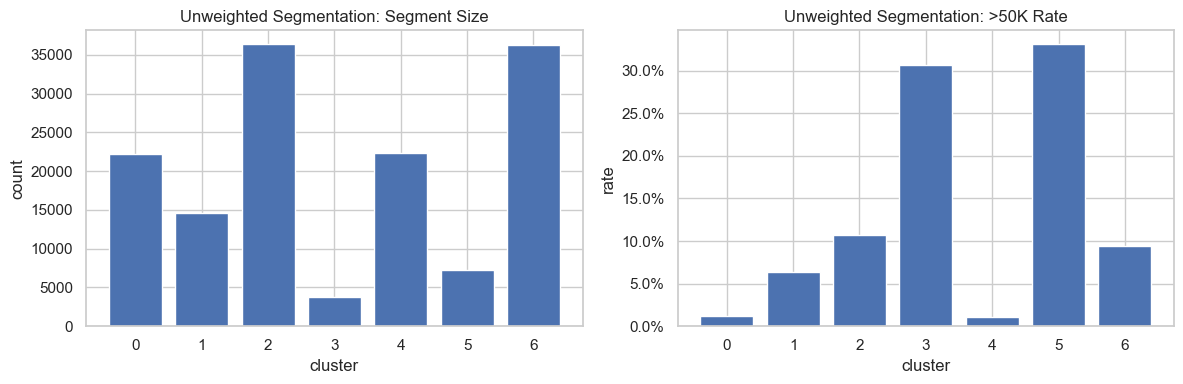

/var/folders/4b/jnhcg4zs2b354pjs5qnb6x2r0000gn/T/ipykernel_36656/534399599.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grp = df.groupby("cluster").apply(


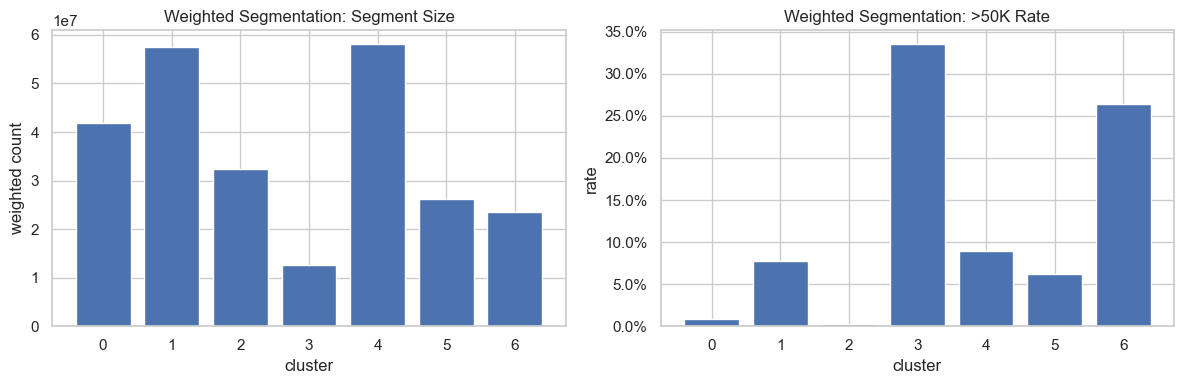

In [35]:
# segment sizes + income rate chart
def plot_segment_rates(clusters, y, title, weights=None):
    df = pd.DataFrame({"cluster": clusters, "label": y.values}, index=y.index)

    if weights is None:
        grp = df.groupby("cluster").agg(size=("label", "size"), pos_rate=("label", "mean"))
    else:
        df["w"] = weights
        grp = df.groupby("cluster").apply(
            lambda g: pd.Series({
                "size": g["w"].sum(),
                "pos_rate": (g["label"] * g["w"]).sum() / g["w"].sum()
            })
        )

    grp = grp.sort_index()

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].bar(grp.index.astype(str), grp["size"].values)
    axes[0].set_title(f"{title}: Segment Size")
    axes[0].set_xlabel("cluster")
    axes[0].set_ylabel("count" if weights is None else "weighted count")

    axes[1].bar(grp.index.astype(str), grp["pos_rate"].values)
    axes[1].set_title(f"{title}: >50K Rate")
    axes[1].set_xlabel("cluster")
    axes[1].set_ylabel("rate")
    axes[1].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

    plt.tight_layout()
    plt.show()

plot_segment_rates(clusters_unw, y_fe, "Unweighted Segmentation", weights=None)
plot_segment_rates(clusters_w,   y_fe, "Weighted Segmentation", weights=weights)


## 4.1) Detailed Cluster Profiling - Key Demographics

Let's examine how clusters differ across critical demographic and economic variables.

In [36]:
# Create a detailed comparison dataframe for the weighted clustering
dfp_w = X_fe.copy()
dfp_w["cluster"] = clusters_w
dfp_w["label"] = y_fe.values
dfp_w["weight"] = weights

# Compute key statistics per cluster
cluster_stats = []
for c in sorted(dfp_w["cluster"].unique()):
    sub = dfp_w[dfp_w["cluster"] == c]
    w = sub["weight"]
    
    cluster_stats.append({
        "Cluster": c,
        "Size (weighted)": w.sum(),
        "Avg Age": weighted_mean(sub["age"], w),
        "% Male": weighted_mean(sub["is_male"], w) * 100,
        "% White": weighted_mean(sub["is_white"], w) * 100,
        "Avg Weeks Worked": weighted_mean(sub["weeks worked in year"], w),
        "% w/ Capital Gains": weighted_mean(sub["has_capital_gains"], w) * 100,
        "% w/ Dividends": weighted_mean(sub["has_dividends_from_stocks"], w) * 100,
        "Income >50K %": weighted_mean(sub["label"], w) * 100
    })

cluster_summary = pd.DataFrame(cluster_stats).sort_values("Size (weighted)", ascending=False)

# Create formatted version for display
cluster_summary_display = cluster_summary.copy()
cluster_summary_display["Size (weighted)"] = cluster_summary_display["Size (weighted)"].apply(lambda x: f"{x:,.0f}")
cluster_summary_display["Avg Age"] = cluster_summary_display["Avg Age"].apply(lambda x: f"{x:.1f}")
cluster_summary_display["% Male"] = cluster_summary_display["% Male"].apply(lambda x: f"{x:.1f}%")
cluster_summary_display["% White"] = cluster_summary_display["% White"].apply(lambda x: f"{x:.1f}%")
cluster_summary_display["Avg Weeks Worked"] = cluster_summary_display["Avg Weeks Worked"].apply(lambda x: f"{x:.1f}")
cluster_summary_display["% w/ Capital Gains"] = cluster_summary_display["% w/ Capital Gains"].apply(lambda x: f"{x:.1f}%")
cluster_summary_display["% w/ Dividends"] = cluster_summary_display["% w/ Dividends"].apply(lambda x: f"{x:.1f}%")
cluster_summary_display["Income >50K %"] = cluster_summary_display["Income >50K %"].apply(lambda x: f"{x:.1f}%")

display(cluster_summary_display)

,Cluster,Size (weighted),Avg Age,% Male,% White,Avg Weeks Worked,% w/ Capital Gains,% w/ Dividends,Income >50K %
4,4,"58,025,563",38.9,52.2%,83.1%,47.4,0.0%,4.0%,8.9%
1,1,"57,517,012",38.7,52.2%,83.9%,47.3,0.0%,3.5%,7.7%
0,0,"41,794,412",70.1,37.0%,86.8%,0.8,0.1%,5.0%,0.9%
2,2,"32,482,427",31.6,32.0%,73.3%,2.6,0.0%,2.1%,0.2%
5,5,"26,135,937",33.1,53.0%,87.2%,43.7,0.1%,8.9%,6.2%
6,6,"23,491,521",51.4,48.8%,94.5%,34.2,0.0%,100.0%,26.4%
3,3,"12,681,320",48.5,72.8%,89.2%,39.6,100.0%,28.6%,33.5%


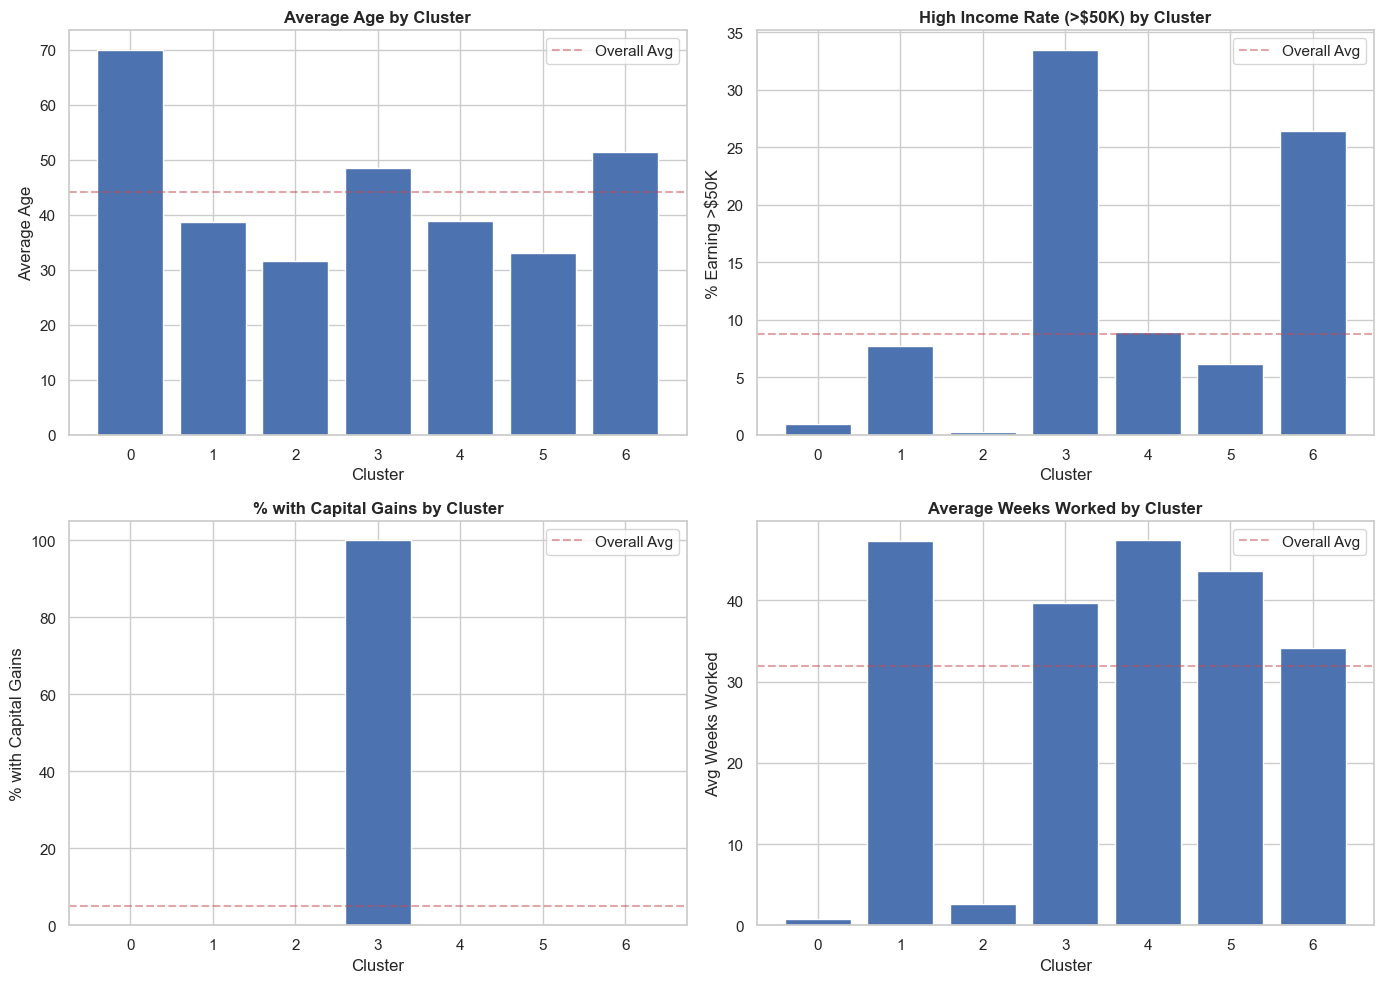

In [ ]:
# Visualize key demographic differences across clusters
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
cluster_summary_sorted = cluster_summary.sort_values("Cluster")
cluster_labels = cluster_summary_sorted["Cluster"].astype(str)

# Age distribution
axes[0, 0].bar(cluster_labels, cluster_summary_sorted["Avg Age"])
axes[0, 0].set_title("Average Age by Cluster", fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel("Cluster")
axes[0, 0].set_ylabel("Average Age")
axes[0, 0].axhline(y=weighted_mean(dfp_w["age"], dfp_w["weight"]), color='r', linestyle='--', alpha=0.5, label='Overall Avg')
axes[0, 0].legend()

# Income rate
axes[0, 1].bar(cluster_labels, cluster_summary_sorted["Income >50K %"])
axes[0, 1].set_title("High Income Rate (>$50K) by Cluster", fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel("Cluster")
axes[0, 1].set_ylabel("% Earning >$50K")
axes[0, 1].axhline(y=weighted_mean(dfp_w["label"], dfp_w["weight"]) * 100, color='r', linestyle='--', alpha=0.5, label='Overall Avg')
axes[0, 1].legend()

# Capital gains
axes[1, 0].bar(cluster_labels, cluster_summary_sorted["% w/ Capital Gains"])
axes[1, 0].set_title("% with Capital Gains by Cluster", fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel("Cluster")
axes[1, 0].set_ylabel("% with Capital Gains")
axes[1, 0].axhline(y=weighted_mean(dfp_w["has_capital_gains"], dfp_w["weight"]) * 100, color='r', linestyle='--', alpha=0.5, label='Overall Avg')
axes[1, 0].legend()

# Weeks worked
axes[1, 1].bar(cluster_labels, cluster_summary_sorted["Avg Weeks Worked"])
axes[1, 1].set_title("Average Weeks Worked by Cluster", fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel("Cluster")
axes[1, 1].set_ylabel("Avg Weeks Worked")
axes[1, 1].axhline(y=weighted_mean(dfp_w["weeks worked in year"], dfp_w["weight"]), color='r', linestyle='--', alpha=0.5, label='Overall Avg')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

## 4.2) Categorical Features by Cluster

In [ ]:
# analyze categorical features for each cluster
def get_top_categories_by_cluster(dfp, cluster_col, cat_feature, weights_col=None, top_n=3):
    """Get the top N categories for a feature in each cluster"""
    results = {}
    for c in sorted(dfp[cluster_col].unique()):
        sub = dfp[dfp[cluster_col] == c]
        if weights_col:
            vc = sub.groupby(cat_feature)[weights_col].sum().sort_values(ascending=False)
        else:
            vc = sub[cat_feature].value_counts()
        results[c] = vc.head(top_n).index.tolist()
    return results

# get top categories for key features
education_by_cluster = get_top_categories_by_cluster(dfp_w, "cluster", "education", "weight", top_n=3)
occupation_by_cluster = get_top_categories_by_cluster(dfp_w, "cluster", "major occupation code", "weight", top_n=3)
industry_by_cluster = get_top_categories_by_cluster(dfp_w, "cluster", "major industry code", "weight", top_n=3)
marital_by_cluster = get_top_categories_by_cluster(dfp_w, "cluster", "marital stat", "weight", top_n=2)

categorical_profiles = []
for c in sorted(dfp_w["cluster"].unique()):
    categorical_profiles.append({
        "Cluster": c,
        "Top Education Levels": " | ".join(education_by_cluster[c]),
        "Top Occupations": " | ".join(occupation_by_cluster[c]),
        "Top Industries": " | ".join(industry_by_cluster[c]),
        "Top Marital Status": " | ".join(marital_by_cluster[c])
    })

cat_profile_df = pd.DataFrame(categorical_profiles)
display(cat_profile_df)

,Cluster,Top Education Levels,Top Occupations,Top Industries,Top Marital Status
0,0,Less than high school | High school graduate | Some college,Not in universe | Farming forestry and fishing | Other service,Not in universe or children | Agriculture | Retail trade,Married-civilian spouse present | Widowed
1,1,High school graduate | Some college | Bachelor's degree,Adm support including clerical | Professional specialty | Other service,Retail trade | Manufacturing-durable goods | Manufacturing-nondurable goods,Married-civilian spouse present | Never married
2,2,High school graduate | Less than high school | Some college,Not in universe | Other service | Adm support including clerical,Not in universe or children | Retail trade | Business and repair services,Never married | Married-civilian spouse present
3,3,High school graduate | Bachelor's degree | Some college,Not in universe | Executive admin and managerial | Professional specialty,Not in universe or children | Manufacturing-durable goods | Retail trade,Married-civilian spouse present | Never married
4,4,High school graduate | Some college | Bachelor's degree,Adm support including clerical | Professional specialty | Other service,Retail trade | Manufacturing-durable goods | Education,Married-civilian spouse present | Never married
5,5,High school graduate | Some college | Bachelor's degree,Adm support including clerical | Professional specialty | Other service,Retail trade | Education | Manufacturing-durable goods,Married-civilian spouse present | Never married
6,6,Bachelor's degree | High school graduate | Graduate degree,Not in universe | Professional specialty | Executive admin and managerial,Not in universe or children | Education | Manufacturing-durable goods,Married-civilian spouse present | Never married


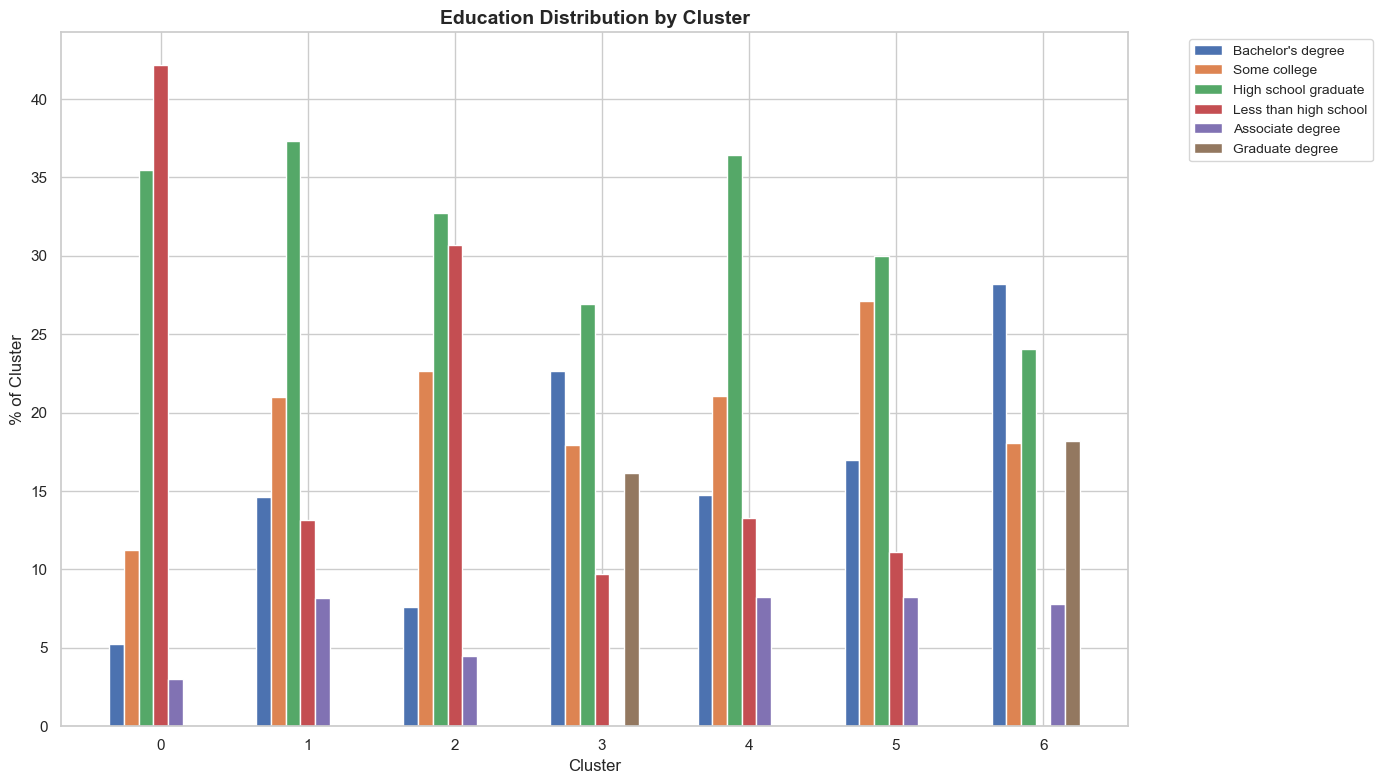

In [ ]:
# Visualize Education Distribution by Cluster
fig, ax = plt.subplots(figsize=(14, 8))

# 1. Education distribution by cluster
education_data = []
clusters_sorted = sorted(dfp_w["cluster"].unique())
for c in clusters_sorted:
    sub = dfp_w[dfp_w["cluster"] == c]
    edu_dist = sub.groupby("education")["weight"].sum().sort_values(ascending=False).head(5)
    education_data.append(edu_dist)

# Plot education
edu_categories = list(set([cat for dist in education_data for cat in dist.index]))[:7]  # Top 7 overall
edu_matrix = []
for c, dist in zip(clusters_sorted, education_data):
    row = [dist.get(cat, 0) / dfp_w[dfp_w["cluster"] == c]["weight"].sum() * 100 for cat in edu_categories]
    edu_matrix.append(row)

x = np.arange(len(clusters_sorted))
width = 0.1
for i, cat in enumerate(edu_categories):
    values = [edu_matrix[j][i] for j in range(len(clusters_sorted))]
    ax.bar(x + i*width, values, width, label=cat[:25] if len(cat) > 25 else cat)

ax.set_xlabel('Cluster', fontsize=12)
ax.set_ylabel('% of Cluster', fontsize=12)
ax.set_title('Education Distribution by Cluster', fontsize=14, fontweight='bold')
ax.set_xticks(x + width * 3)
ax.set_xticklabels(clusters_sorted)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

plt.tight_layout()
plt.show()

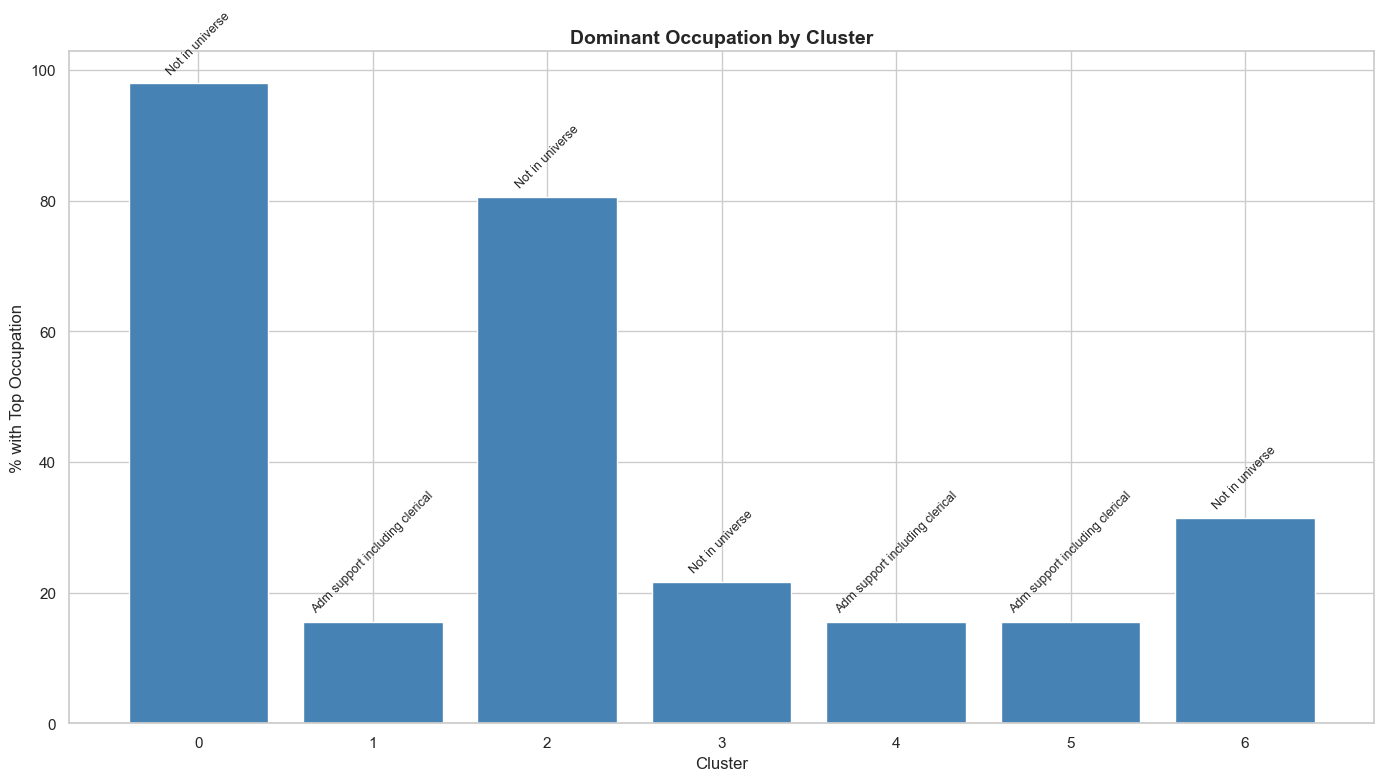

In [40]:
# Visualize Dominant Occupation by Cluster
fig, ax = plt.subplots(figsize=(14, 8))

# Get top occupation for each cluster using utility function
occ_data = get_top_category_by_cluster(dfp_w, "cluster", "major occupation code", "weight", top_n=1)

clusters_plot = list(occ_data.keys())
occ_pcts = [occ_data[c][0][1] for c in clusters_plot]  # [0][1] gets the percentage from first result
occ_labels = [occ_data[c][0][0][:40] for c in clusters_plot]  # [0][0] gets the category name

# Create bar chart
bars = ax.bar(range(len(clusters_plot)), occ_pcts, color='steelblue')
setup_bar_chart(ax, 'Dominant Occupation by Cluster', ylabel='% with Top Occupation')
ax.set_xticks(range(len(clusters_plot)))
ax.set_xticklabels(clusters_plot)

# Add occupation labels on bars
add_labels_on_bars(ax, bars, occ_labels, rotation=45, fontsize=9)

plt.tight_layout()
plt.show()

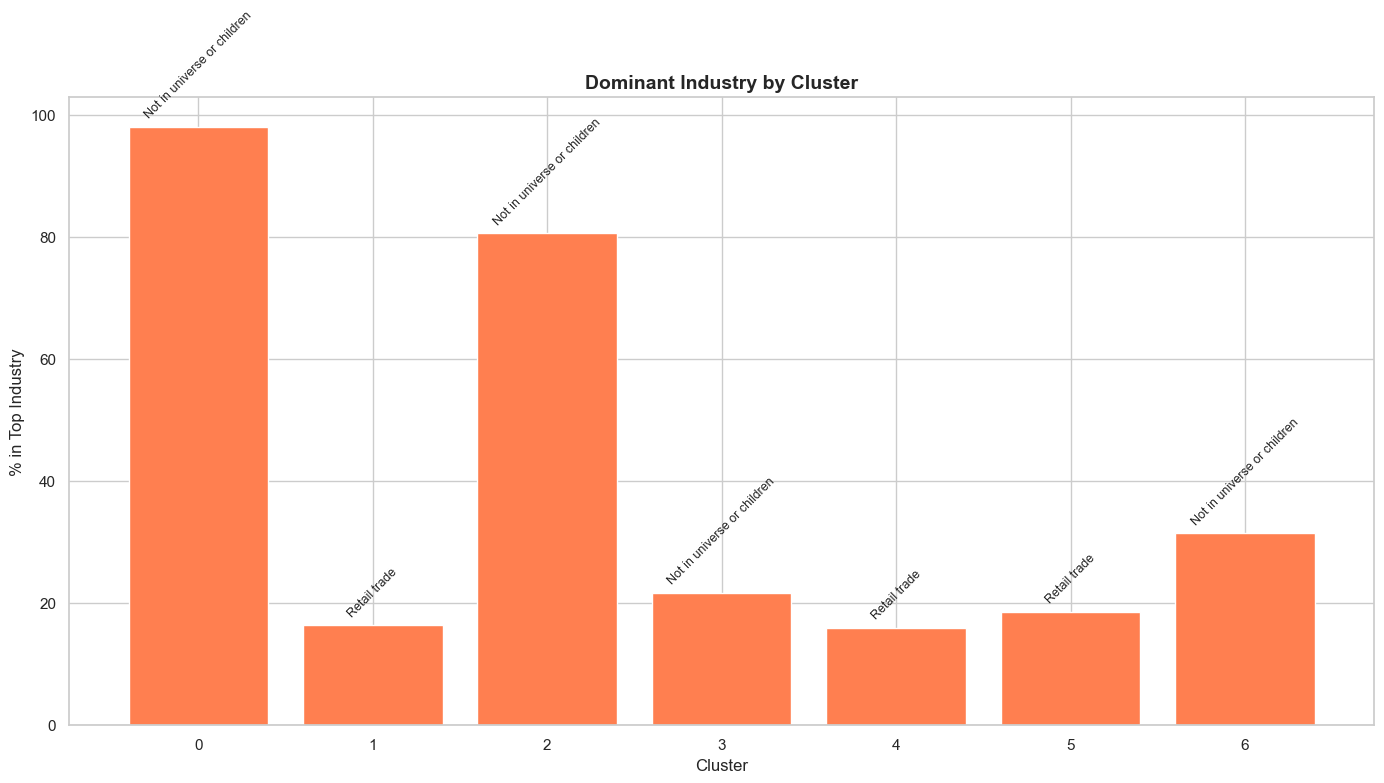

In [41]:
# Visualize Dominant Industry by Cluster
fig, ax = plt.subplots(figsize=(14, 8))

# Get top industry for each cluster using utility function
ind_data = get_top_category_by_cluster(dfp_w, "cluster", "major industry code", "weight", top_n=1)

clusters_plot = list(ind_data.keys())
ind_pcts = [ind_data[c][0][1] for c in clusters_plot]
ind_labels = [ind_data[c][0][0][:40] for c in clusters_plot]

# Create bar chart
bars = ax.bar(range(len(clusters_plot)), ind_pcts, color='coral')
setup_bar_chart(ax, 'Dominant Industry by Cluster', ylabel='% in Top Industry')
ax.set_xticks(range(len(clusters_plot)))
ax.set_xticklabels(clusters_plot)

# Add industry labels on bars
add_labels_on_bars(ax, bars, ind_labels, rotation=45, fontsize=9)

plt.tight_layout()
plt.show()

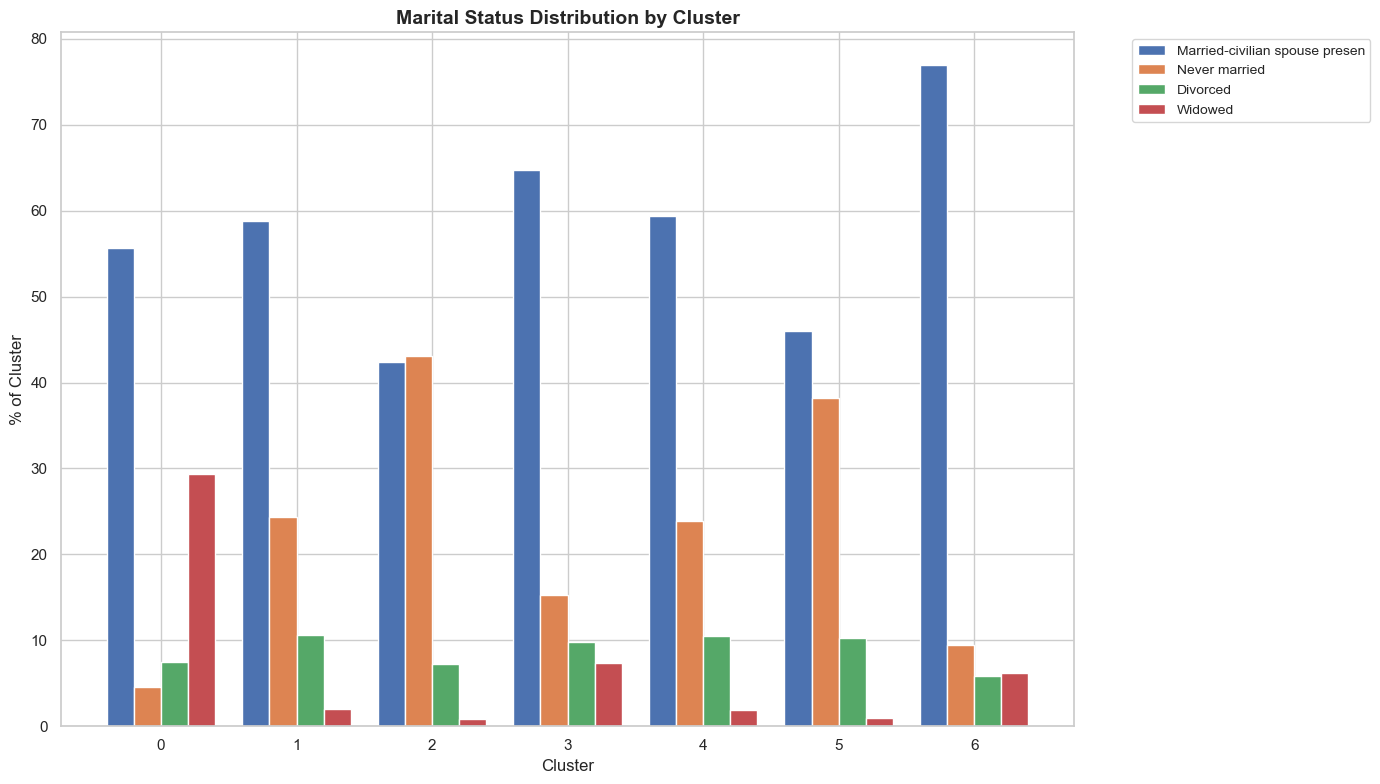

In [42]:
# Visualize Marital Status Distribution by Cluster
fig, ax = plt.subplots(figsize=(14, 8))

# Get marital status distribution using utility function
clusters_sorted = get_clusters_sorted(dfp_w)
marital_pcts = calculate_category_percentage(dfp_w, "cluster", "marital stat", "weight")

# Get top 4 marital status categories overall
TOP_N_MARITAL = 4
marital_categories = dfp_w['marital stat'].value_counts().head(TOP_N_MARITAL).index.tolist()

# Build matrix for plotting
marital_matrix = []
for c in clusters_sorted:
    row = [marital_pcts[c].get(cat, 0) for cat in marital_categories]
    marital_matrix.append(row)

# Plot grouped bar chart
x = np.arange(len(clusters_sorted))
BAR_WIDTH = 0.2
for i, cat in enumerate(marital_categories):
    values = [marital_matrix[j][i] for j in range(len(clusters_sorted))]
    ax.bar(x + i*BAR_WIDTH, values, BAR_WIDTH, label=cat[:30] if len(cat) > 30 else cat)

setup_bar_chart(ax, 'Marital Status Distribution by Cluster', ylabel='% of Cluster')
ax.set_xticks(x + BAR_WIDTH * 1.5)
ax.set_xticklabels(clusters_sorted)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

plt.tight_layout()
plt.show()